# Sarcam Detection from memes

In [1]:
!pip install Pillow # used to resize images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time
import pandas as pd

from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
colab_root = "/content/drive"
csv_path = os.path.join(colab_root, 'My Drive','memotion_analysis_training_data', 'data_7000_new.csv')
data_dfile_path = os.path.join(colab_root, "My Drive","memotion_analysis_training_data", 'data_7000')

In [0]:
df = pd.read_csv(csv_path, header=None, names=["img_name", "url", "text", "text1", "funny_tag", "sarcasm_tag", "offensive_tag", "motivation_tag", "positive_tag"])
df.head(5)

,img_name,url,text,text1,funny_tag,sarcasm_tag,offensive_tag,motivation_tag,positive_tag
0,10_year_2r94rv.jpg,https://i.imgflip.com/2r94rv.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,10_year_10-year-challenge_1547788782.jpeg,https://spiderimg.amarujala.com/assets/images/...,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,https://www.lifewire.com/thmb/8wNfd94_meE9X2cp...,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,10_year_10-year-challenge-sweet-dee-edition-40...,https://pics.conservativememes.com/10-year-cha...,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,10_year_10-year-challenge-with-no-filter-47-hi...,https://pics.me.me/10-year-challenge-with-no-f...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [0]:
df['funny_tag'].value_counts()

funny              2291
very_funny         2075
not_funny          1551
hilarious           604
general              39
not_sarcastic        19
twisted_meaning      12
not_offensive         4
very_twisted          3
very_offensive        2
slight                1
Name: funny_tag, dtype: int64

There is a high class imbalance tags associated with the sarcasm class. We have combined tags belonging to twisted meaning and very_twisted meaning as sarcasm class. As the number of tags for not_sarcastic is the least 1449 we have undersampled the general and sarcasm class. The categories like not_offensive, slight, very_offensive, motivational and not_motivational  have been excluded as they very few samples.
The total number of tags for each class are now the same across 3 categories viz. general, sarcastic and not-sarcastic.


In [0]:
df['sarcasm_tag'].value_counts()

general             3258
twisted_meaning     1451
not_sarcastic       1449
very_twisted         363
not_offensive         34
slight                27
very_offensive        12
not_motivational       5
motivational           2
Name: sarcasm_tag, dtype: int64

In [0]:
df['offensive_tag'].value_counts()

not_offensive        2542
slight               2408
very_offensive       1364
hateful_offensive     207
not_motivational       46
motivational           27
very_positive           4
positive                3
Name: offensive_tag, dtype: int64

In [0]:
df['motivation_tag'].value_counts()

not_motivational    4229
motivational        2292
positive              39
neutral               16
very_positive         11
negative               4
very_negative          3
Name: motivation_tag, dtype: int64

In [0]:
df['positive_tag'].value_counts()

positive                                                          2912
neutral                                                           2073
very_positive                                                      958
negative                                                           439
very_negative                                                      138
positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg       1
Name: positive_tag, dtype: int64

In [0]:
df['sarcasm_tag'].value_counts()

general             3258
twisted_meaning     1451
not_sarcastic       1449
very_twisted         363
not_offensive         34
slight                27
very_offensive        12
not_motivational       5
motivational           2
Name: sarcasm_tag, dtype: int64

#Data Preprocessing
We combine tags with label twisted meaning and very twisted meaning within the sarcasm category 

In [0]:
df['sarcasm_tag'] = df.sarcasm_tag.apply(lambda x: "sarcasm" if x=='twisted_meaning' else x)
df['sarcasm_tag'] = df.sarcasm_tag.apply(lambda x: "sarcasm" if x=='very_twisted' else x)

In [0]:
df['sarcasm_tag'].value_counts()

general             3258
sarcasm             1814
not_sarcastic       1449
not_offensive         34
slight                27
very_offensive        12
not_motivational       5
motivational           2
Name: sarcasm_tag, dtype: int64

In [0]:
df = df[df.sarcasm_tag != "not_offensive"]
df = df[df.sarcasm_tag != "slight"]
df = df[df.sarcasm_tag != "very_offensive"]
df = df[df.sarcasm_tag != "not_motivational"]
df = df[df.sarcasm_tag != "motivational"]

In [0]:
df['sarcasm_tag'].value_counts()

general          3258
sarcasm          1814
not_sarcastic    1449
Name: sarcasm_tag, dtype: int64

In [0]:
!du -sh '/content/drive/My Drive/adl_project/resized.zip'

124M	/content/drive/My Drive/adl_project/resized.zip


In [0]:
!unzip -q '/content/drive/My Drive/adl_project/resized_data.zip' -d '/content/resized'

In [0]:
df.drop(columns=['url', 'text', 'funny_tag', 'offensive_tag', 'motivation_tag', 'positive_tag'], inplace=True)

In [0]:
df['img_name'] = '/content/drive/My Drive/adl_project/resized/' + df['img_name'].astype('str')

In [0]:
df['img_name']

0       /content/drive/My Drive/adl_project/resized/10...
1       /content/drive/My Drive/adl_project/resized/10...
2       /content/drive/My Drive/adl_project/resized/10...
3       /content/drive/My Drive/adl_project/resized/10...
4       /content/drive/My Drive/adl_project/resized/10...
                              ...                        
6596    /content/drive/My Drive/adl_project/resized/be...
6597    /content/drive/My Drive/adl_project/resized/be...
6598    /content/drive/My Drive/adl_project/resized/be...
6599    /content/drive/My Drive/adl_project/resized/be...
6600    /content/drive/My Drive/adl_project/resized/be...
Name: img_name, Length: 6521, dtype: object

In [0]:
df.columns

Index(['img_name', 'text1', 'sarcasm_tag'], dtype='object')

In [0]:
df.loc[0, ['img_name']][0]

'/content/drive/My Drive/adl_project/resized/10_year_2r94rv.jpg'

In [0]:
def show_data(i):
  print(df.loc[i, ['text1']][0])
  print(df.loc[i, ['sarcasm_tag']][0])
  plt.imshow(mpimg.imread(df.loc[i, ['img_name']][0]))

In [0]:
from glob import glob
size = 299, 299

df_old = pd.read_csv(csv_path, header=None, names=["img_name", "url", "text", "text1", "funny_tag", "sarcasm_tag", "offensive_tag", "motivation_tag", "positive_tag"])

img_names = list(set(df_old['img_name']))
print(len(img_names))

6600


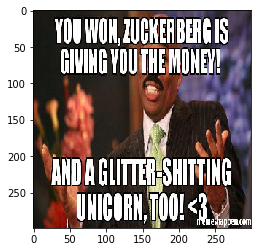

In [0]:
im = Image.open("/content/drive/My Drive/memotion_analysis_training_data/data_7000/"+img_names[0])
im = im.resize(size)
plt.imshow(im)
#out_file = os.path.join("/content/dump/", img_names[0])
#im.save(out_file)

In [0]:
ctr=1
for infile in img_names:
  im = Image.open("/content/drive/My Drive/memotion_analysis_training_data/data_7000/"+infile)
  print(ctr)
  try:
    rgb_im = im.convert('RGB')
    infile = infile.split('.')[0]+".jpg"
    rgb_im.save("/content/resized_images_old/"+infile)
    ctr+=1
  except:
    print('error here',infile)

In [0]:
!du -sh '/content/resized_images_old'

du: cannot access '/content/resized_images_old': No such file or directory


In [0]:
img_names = os.listdir('/content/resized')

In [0]:
for infile in img_names:
  im = Image.open("/content/resized_images_old/"+infile)
  im = im.resize(size)
  out_file = os.path.join("/content/resized_images/", infile)
  im.save(out_file)

In [0]:
!du -sh '/content/resized_images'

139M	/content/resized_images


In [0]:
shutil.make_archive('resized', 'zip', '/content/resized_images')

'/content/resized.zip'

In [0]:
from google.colab import files
files.download('/content/resized.zip')

In [0]:
import csv
coco_images_folder = os.listdir('/content/drive/My Drive/adl_project/resized')
coco_images_folder[0:4]

['distracted_bf_242c8b.jpg',
 'zeck_01d16e0252a39cadfc1cc2a425376498.jpg',
 'avengers_6183831-2596735226-a4c2c.jpg',
 'bethe_59flqeDoU.jpg']

In [0]:
img_names = list(df['img_name'])
len(img_names)

6521

In [0]:
my_images = []
for i in img_names:
  i=i.replace('/content/drive/My Drive/adl_project/resized/', '')
  my_images.append(i)

In [0]:
list(set(my_images))

In [0]:
sarcastic = df[df['sarcasm_tag']=="sarcasm"]
sarcastic.head()

,img_name,text1,sarcasm_tag
3,/content/drive/My Drive/adl_project/resized/10...,10 Year Challenge - Sweet Dee Edition,sarcasm
4,/content/drive/My Drive/adl_project/resized/10...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,sarcasm
7,/content/drive/My Drive/adl_project/resized/10...,10 Year Challenge emotional edition boredpanda...,sarcasm
11,/content/drive/My Drive/adl_project/resized/10...,State Dining Room in the White House: 2009 vs....,sarcasm
16,/content/drive/My Drive/adl_project/resized/10...,When you wakeup and read the messages you sent...,sarcasm


In [0]:
general = df[df['sarcasm_tag']=="general"]
general.head()

,img_name,text1,sarcasm_tag
0,/content/drive/My Drive/adl_project/resized/10...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,general
1,/content/drive/My Drive/adl_project/resized/10...,The best of #10 YearChallenge! Completed in le...,general
5,/content/drive/My Drive/adl_project/resized/10...,"1998: ""Don't get in car with strangers"" 2008: ...",general
9,/content/drive/My Drive/adl_project/resized/10...,FACEBOOK '10 YEAR CHALLENGE': A PLOY OR A SIMP...,general
10,/content/drive/My Drive/adl_project/resized/10...,PROBABLY THE FIRST MAN TO DO 10 YEAR CHALLENGE...,general


In [0]:
not_sarcastic = df[df['sarcasm_tag']=="not_sarcastic"]
not_sarcastic.head()

,img_name,text1,sarcasm_tag
2,/content/drive/My Drive/adl_project/resized/10...,Sam Thorne @Strippin ( Follow Follow Saw every...,not_sarcastic
6,/content/drive/My Drive/adl_project/resized/10...,10 years challenge is lit af Üs & B erg 1945 1...,not_sarcastic
8,/content/drive/My Drive/adl_project/resized/10...,Fornite died in 10 months but Minecraft never ...,not_sarcastic
14,/content/drive/My Drive/adl_project/resized/10...,Anti-vaxx kids when they see someone doing the...,not_sarcastic
19,/content/drive/My Drive/adl_project/resized/av...,NO SPOILERS FOR AVENGERS INFINITY WAR! THANOS ...,not_sarcastic


In [0]:
general = general.sample(frac=1).reset_index(drop=True)
general.head(3)

,img_name,text1,sarcasm_tag
0,/content/drive/My Drive/adl_project/resized/tr...,DONALD TRUMP DONALD T. DON T. DON'T. GLAD WE H...,general
1,/content/drive/My Drive/adl_project/resized/mo...,Troll Bollywood Memes YUVI WITH MODI INVITING ...,general
2,/content/drive/My Drive/adl_project/resized/de...,"LEONARDO DICAPRIO WINNING THE ""BEST ACTOR"" Osc...",general


In [0]:
sarcastic = sarcastic.sample(frac=1).reset_index(drop=True)
not_sarcastic = not_sarcastic.sample(frac=1).reset_index(drop=True)

Splitting the dataset into train-test-split with 70-15-15% of data respectively

In [0]:
x_train = pd.concat([general.iloc[0:1000], sarcastic.iloc[0:1000], not_sarcastic.iloc[0:1000]], axis=0)
x_val = pd.concat([general.iloc[1000:1225, :], sarcastic.iloc[1000:1225, :], not_sarcastic.iloc[1000:1225, :]], axis=0)
x_test = pd.concat([general.iloc[1225:1449, :], sarcastic.iloc[1225:1449, :], not_sarcastic.iloc[1225:1449, :]], axis=0)


In [0]:
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)

In [0]:
x_train.head()

,img_name,text1,sarcasm_tag
0,/content/drive/My Drive/adl_project/resized/tr...,DONALD TRUMP DONALD T. DON T. DON'T. GLAD WE H...,general
1,/content/drive/My Drive/adl_project/resized/mo...,Troll Bollywood Memes YUVI WITH MODI INVITING ...,general
2,/content/drive/My Drive/adl_project/resized/de...,"LEONARDO DICAPRIO WINNING THE ""BEST ACTOR"" Osc...",general
3,/content/drive/My Drive/adl_project/resized/de...,ONLY I CAN USE DICAPRIO MEMES ALAN WNG memegen...,general
4,/content/drive/My Drive/adl_project/resized/pe...,When your younger sibling asks why you never l...,general


In [0]:
x_test.head()

,img_name,text1,sarcasm_tag
0,/content/drive/My Drive/adl_project/resized/sp...,I FAILED. I'M NOT SUPERMAN [JK YES I AM memege...,general
1,/content/drive/My Drive/adl_project/resized/ca...,when you want to get in shape for summer but l...,general
2,/content/drive/My Drive/adl_project/resized/jo...,CHILDHOOD IS WHEN YOU IDOLIZE BATMAN ADULTHOOD...,general
3,/content/drive/My Drive/adl_project/resized/av...,"Remember. Dr. Strange watched the ""Endgame"" fo...",general
4,/content/drive/My Drive/adl_project/resized/10...,I did the Facebook 10 year challenge and it wa...,general


In [0]:
x_val.head()

,img_name,text1,sarcasm_tag
0,/content/drive/My Drive/adl_project/resized/fr...,"THE DIFFERENCE BETWEEN ""GIRLFRIEND AND ""GIRL F...",general
1,/content/drive/My Drive/adl_project/resized/ha...,HAPPY FRIDAY! WAIT SORRY ITS MONDAY.,general
2,/content/drive/My Drive/adl_project/resized/se...,OH MAN THIS IS GONNA WHISK HER OFF HER FEET,general
3,/content/drive/My Drive/adl_project/resized/be...,Mr bean The real inventor of selfies JUDE 3 Th...,general
4,/content/drive/My Drive/adl_project/resized/ha...,HAPPY 21ST BIRTHDAY SORRY NO WAIT! I MEAN 61S...,general


In [0]:
x_train.to_csv('x_train.csv', index=False)
x_test.to_csv('x_test.csv', index=False)
x_val.to_csv('x_val.csv', index=False)

In [0]:
x_train = pd.read_csv('/content/drive/My Drive/adl_project/data/Memotion_train_new.csv')
x_test = pd.read_csv('/content/drive/My Drive/adl_project/data/Memotion_test_new.csv')
x_val = pd.read_csv('/content/drive/My Drive/adl_project/data/Memotion_val_new.csv')


In [5]:
x_train['sarcasm_tag'].value_counts()

general          1000
not_sarcastic    1000
sarcasm          1000
Name: sarcasm_tag, dtype: int64

Converting from categorical to numeric labels.
Class 0 stands for general, 1.0 for sarcasm and 2.0 for not sarcasm.

In [0]:
x_train['sarcasm_tag'] = x_train['sarcasm_tag'].apply(lambda x: 0.0 if x=="general" else (1.0 if x=="sarcasm" else 2.0))

In [0]:
x_test['sarcasm_tag'] = x_test['sarcasm_tag'].apply(lambda x: 0.0 if x=="general" else (1.0 if x=="sarcasm" else 2.0))
x_val['sarcasm_tag'] = x_val['sarcasm_tag'].apply(lambda x: 0.0 if x=="general" else (1.0 if x=="sarcasm" else 2.0))

In [8]:
x_train['sarcasm_tag'].value_counts()

2.0    1000
1.0    1000
0.0    1000
Name: sarcasm_tag, dtype: int64

In [10]:
x_test['sarcasm_tag'].value_counts()

2.0    224
1.0    224
0.0    224
Name: sarcasm_tag, dtype: int64

In [11]:
x_val['sarcasm_tag'].value_counts()

2.0    225
1.0    225
0.0    225
Name: sarcasm_tag, dtype: int64

In [0]:
x_test['img_name']=x_test['img_name'].apply(lambda x: os.path.join('resized_data',x.split('resized/')[1]))
x_train['img_name']=x_train['img_name'].apply(lambda x: os.path.join('resized_data',x.split('resized/')[1]))
x_val['img_name']=x_val['img_name'].apply(lambda x: os.path.join('resized_data',x.split('resized/')[1]))

In [13]:
print(len(x_train), len(x_val), len(x_test))

3000 675 672


In [0]:
x_train = x_train.sample(frac=1).reset_index(drop=True)
x_test = x_test.sample(frac=1).reset_index(drop=True)
x_val = x_val.sample(frac=1).reset_index(drop=True)

In [0]:
labels_train = x_train['sarcasm_tag'].astype('float32')
labels_test = x_test['sarcasm_tag'].astype('float32')
labels_val = x_val['sarcasm_tag'].astype('float32')


In [16]:
images_train = x_train['img_name']
images_test = x_test['img_name']
images_val = x_val['img_name']

text_train = x_train['text1'].astype('str')
text_test = x_test['text1'].astype('str')
text_val = x_val['text1'].astype('str')


print(len(images_train), len(text_train), len(labels_train))
print(len(images_test), len(text_test), len(labels_test))
print(len(images_val), len(text_val), len(labels_val))


3000 3000 3000
672 672 672
675 675 675


In [0]:
x_train['text1'] = x_train['text1'].str.lower()
x_test['text1'] = x_test['text1'].str.lower()
x_val['text1'] = x_val['text1'].str.lower()

In [0]:
def preprocess(df):
  df['text1'] = df.text1.str.replace('\w*.com[\w\W]*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.co[\w\W]*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.net', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.strangely', '', regex=True)
  df['text1'] = df.text1.str.replace('www.\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.updates', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.EU', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.in', '', regex=True)
  df['text1'] = df.text1.str.replace('http\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*http://\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*https://\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.mobi', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.es', '', regex=True)
  df['text1'] = df.text1.str.replace('via ', '', regex=True)
  df['text1'] = df.text1.str.replace('@\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.book', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.org', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.com/\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('memecenter', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.xyz', '', regex=True)
  df['text1'] = df.text1.str.replace('[^\w\s]','')

  return df

In [0]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)
x_val = preprocess(x_val)

In [20]:
x_train.columns

Index(['img_name', 'text1', 'sarcasm_tag'], dtype='object')

In [0]:
!unzip -q '/content/drive/My Drive/adl_project/resized_data.zip' -d '/content/resized'

In [21]:
sarcastic_train = x_train[x_train['sarcasm_tag'] == 1.0]
sarcastic_train = sarcastic_train['img_name']
print(len(sarcastic_train))

sarcastic_test = x_test[x_test['sarcasm_tag'] == 1.0]
sarcastic_test = sarcastic_test['img_name']
print(len(sarcastic_test))

sarcastic_val = x_val[x_val['sarcasm_tag'] == 1.0]
sarcastic_val = sarcastic_val['img_name']
print(len(sarcastic_val))


1000
224
225


In [22]:
non_sarcastic_train = x_train[x_train['sarcasm_tag'] == 2.0]
non_sarcastic_train = non_sarcastic_train['img_name']
print(len(non_sarcastic_train))

non_sarcastic_test = x_test[x_test['sarcasm_tag'] == 2.0]
non_sarcastic_test = non_sarcastic_test['img_name']
print(len(non_sarcastic_test))

non_sarcastic_val = x_val[x_val['sarcasm_tag'] == 2.0]
non_sarcastic_val = non_sarcastic_val['img_name']
print(len(sarcastic_val))


1000
224
225


In [251]:
reg_train = x_train[x_train['sarcasm_tag'] == 0]
reg_train = reg_train['img_name']
print(len(reg_train))

reg_test = x_test[x_test['sarcasm_tag'] == 0]
reg_test = reg_test['img_name']
print(len(reg_test))

reg_val = x_val[x_val['sarcasm_tag'] == 0]
reg_val = reg_val['img_name']
print(len(sarcastic_val))


1000
224
225


In [256]:
x_train["sarcasm_tag"].value_counts()

1.0    1000
0.0    1000
2.0    1000
Name: sarcasm_tag, dtype: int64

In [257]:
x_test["sarcasm_tag"].value_counts()

2.0    224
1.0    224
0.0    224
Name: sarcasm_tag, dtype: int64

In [258]:
x_val["sarcasm_tag"].value_counts()

1.0    225
2.0    225
0.0    225
Name: sarcasm_tag, dtype: int64

In [0]:
x_train = x_train.sample(frac=1).reset_index(drop=True)
x_test = x_test.sample(frac=1).reset_index(drop=True)
x_val = x_val.sample(frac=1).reset_index(drop=True)

In [0]:
labels_train = x_train['sarcasm_tag'].astype('float32')
labels_test = x_test['sarcasm_tag'].astype('float32')
labels_val = x_val['sarcasm_tag'].astype('float32')


In [0]:
assert len(x_train)==3000
assert len(x_test)==672
assert len(x_val)==675

In [0]:
import matplotlib.pyplot as plt
#Plots showing training and validation loss and accuracy as a function of epochs

def plot(history):
  # The history object contains accuracy and loss for training and test sets for every epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  

## Text Only
a) Using only text from a meme to predict if it sarcasm, not-sarcasm or general meme.

In [0]:
text_train = x_train['text1'].astype('str').values
text_test = x_test['text1'].astype('str').values
text_val = x_val['text1'].astype('str').values

Text preprocessing

In [29]:
VOCAB_SIZE = 3000 # vocabulary size
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE) 
tokenizer.fit_on_texts(text_train)

print("Word index", len(tokenizer.word_index))

Word index 5446


In [0]:
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_val = tokenizer.texts_to_sequences(text_val)
sequences_test = tokenizer.texts_to_sequences(text_test)

In [0]:
MAX_SEQ_LEN = 20 # maximum length of text to consider

In [0]:
padded_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, MAX_SEQ_LEN)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(sequences_val, MAX_SEQ_LEN)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, MAX_SEQ_LEN)

In [277]:
print('Original Question:- ', text_train[0])
print('Encoded from:- ', list(padded_train[0]))
print('Reconverted from token to text:- ', tokenizer.sequences_to_texts([list(padded_train[0])])[0])

Original Question:-  when my fans cry i k their tears 
Encoded from:-  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 13, 276, 1073, 4, 55, 102, 1074]
Reconverted from token to text:-  when my fans cry i k their tears


In [278]:
print('Length of padded sequence:- ', len(padded_train[0]))

Length of padded sequence:-  20


In [33]:
from tensorflow.keras.utils import to_categorical

labels_train1 = to_categorical(labels_train)
labels_test1 = to_categorical(labels_test)
labels_val1 = to_categorical(labels_val)

print(labels_train1.shape, labels_val1.shape, labels_test1.shape)

(3000, 3) (675, 3) (672, 3)


#Using word-embedding without Glove

In [0]:
from tensorflow.keras.layers import Embedding
EMBEDDING_DIM = 300

embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=None,
                            input_length=MAX_SEQ_LEN,
                            trainable=False)

#i) Baseline LSTM model 

In [0]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, TimeDistributed, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

inp = Input(shape=(MAX_SEQ_LEN,))
x = embedding_layer(inp)

x = LSTM(128)(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)

In [284]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)

Train on 3000 samples, validate on 675 samples
Epoch 1/10
3000/3000 [==============================] - 2s 570us/sample - loss: 1.1000 - accuracy: 0.3273 - val_loss: 1.0987 - val_accuracy: 0.3689
Epoch 2/10
3000/3000 [==============================] - 1s 170us/sample - loss: 1.0944 - accuracy: 0.3937 - val_loss: 1.1004 - val_accuracy: 0.3185
Epoch 3/10
3000/3000 [==============================] - 0s 164us/sample - loss: 1.0850 - accuracy: 0.4137 - val_loss: 1.1052 - val_accuracy: 0.3407
Epoch 4/10
3000/3000 [==============================] - 1s 178us/sample - loss: 1.0735 - accuracy: 0.4297 - val_loss: 1.1153 - val_accuracy: 0.3067
Epoch 5/10
3000/3000 [==============================] - 0s 161us/sample - loss: 1.0498 - accuracy: 0.4650 - val_loss: 1.1307 - val_accuracy: 0.3422
Epoch 6/10
3000/3000 [==============================] - 1s 170us/sample - loss: 1.0199 - accuracy: 0.4857 - val_loss: 1.1796 - val_accuracy: 0.3170
Epoch 7/10
3000/3000 [==============================] - 1s 173us/

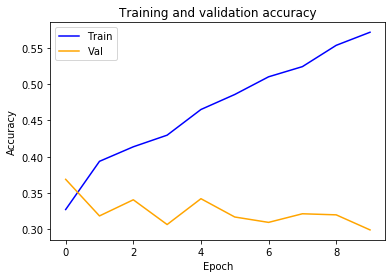

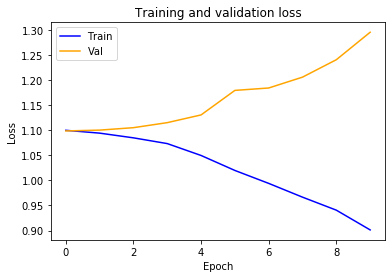

In [285]:
plot(history)

In [0]:
y_pred = model.predict(padded_test)

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [288]:
print(classification_report(x_test['sarcasm_tag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.32      0.27      0.29       224
         1.0       0.32      0.48      0.39       224
         2.0       0.37      0.25      0.30       224

    accuracy                           0.33       672
   macro avg       0.34      0.33      0.33       672
weighted avg       0.34      0.33      0.33       672



This model has an accuracy of 33% 

#ii) Deep LSTM model with Dropout

In [0]:
inp = Input(shape=(MAX_SEQ_LEN,))
x = embedding_layer(inp)

x = LSTM(128)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)

Train on 3000 samples, validate on 675 samples
Epoch 1/10
3000/3000 [==============================] - 2s 623us/sample - loss: 1.1003 - accuracy: 0.3230 - val_loss: 1.0986 - val_accuracy: 0.3348
Epoch 2/10
3000/3000 [==============================] - 1s 173us/sample - loss: 1.0998 - accuracy: 0.3247 - val_loss: 1.0986 - val_accuracy: 0.3481
Epoch 3/10
3000/3000 [==============================] - 1s 176us/sample - loss: 1.0989 - accuracy: 0.3427 - val_loss: 1.0986 - val_accuracy: 0.3141
Epoch 4/10
3000/3000 [==============================] - 1s 176us/sample - loss: 1.0967 - accuracy: 0.3573 - val_loss: 1.1014 - val_accuracy: 0.3467
Epoch 5/10
3000/3000 [==============================] - 1s 169us/sample - loss: 1.0899 - accuracy: 0.3910 - val_loss: 1.1065 - val_accuracy: 0.3244
Epoch 6/10
3000/3000 [==============================] - 1s 185us/sample - loss: 1.0730 - accuracy: 0.4250 - val_loss: 1.1146 - val_accuracy: 0.3259
Epoch 7/10
3000/3000 [==============================] - 1s 182us/

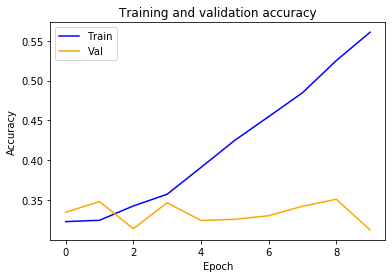

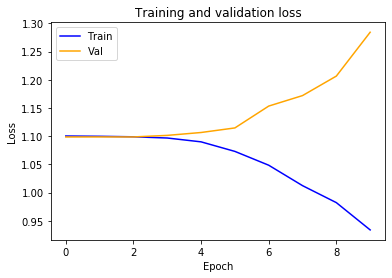

In [40]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)
plot(history)

In [0]:
y_pred = model.predict(padded_test)

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [43]:
from sklearn.metrics import classification_report 
print(classification_report(x_test['sarcasm_tag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.31      0.13      0.19       224
         1.0       0.29      0.25      0.27       224
         2.0       0.33      0.57      0.42       224

    accuracy                           0.32       672
   macro avg       0.31      0.32      0.29       672
weighted avg       0.31      0.32      0.29       672



This model has an accuracy of 32%

#iii) Bidirectional LSTM model with Dropout

In [0]:
inp = Input(shape=(MAX_SEQ_LEN,))
x = embedding_layer(inp)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(64)(x)
x = Dropout(0.5)(x)
x = Dense(32)(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)

Train on 3000 samples, validate on 675 samples
Epoch 1/10
3000/3000 [==============================] - 3s 1ms/sample - loss: 1.1038 - accuracy: 0.3070 - val_loss: 1.0982 - val_accuracy: 0.3319
Epoch 2/10
3000/3000 [==============================] - 1s 254us/sample - loss: 1.0985 - accuracy: 0.3467 - val_loss: 1.0991 - val_accuracy: 0.3452
Epoch 3/10
3000/3000 [==============================] - 1s 253us/sample - loss: 1.0954 - accuracy: 0.3710 - val_loss: 1.1033 - val_accuracy: 0.3289
Epoch 4/10
3000/3000 [==============================] - 1s 256us/sample - loss: 1.0843 - accuracy: 0.3937 - val_loss: 1.1167 - val_accuracy: 0.3481
Epoch 5/10
3000/3000 [==============================] - 1s 276us/sample - loss: 1.0675 - accuracy: 0.4243 - val_loss: 1.1165 - val_accuracy: 0.3348
Epoch 6/10
3000/3000 [==============================] - 1s 257us/sample - loss: 1.0337 - accuracy: 0.4730 - val_loss: 1.1376 - val_accuracy: 0.3185
Epoch 7/10
3000/3000 [==============================] - 1s 262us/sa

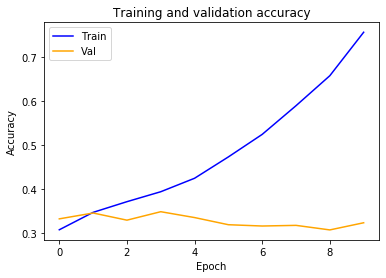

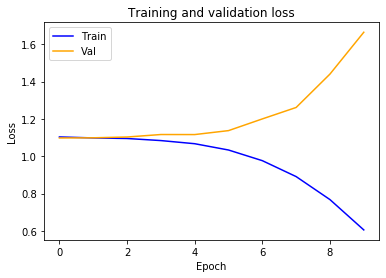

In [312]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)
plot(history)

In [0]:
y_pred = model.predict(padded_test)
y_pred=np.argmax(y_pred, axis=1)

In [314]:
print(classification_report(x_test['sarcasm_tag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.32      0.25      0.28       224
         1.0       0.33      0.38      0.35       224
         2.0       0.33      0.35      0.34       224

    accuracy                           0.33       672
   macro avg       0.33      0.33      0.32       672
weighted avg       0.33      0.33      0.32       672



This model has an accuracy of 33% 

#Correct Predictions

In [0]:
correct_preds=[]
incorrect_preds=[]
for i in range(len(labels_test)):
  if labels_test[i]==y_pred[i]:
    correct_preds.append(i)
  else:
    incorrect_preds.append(i)

Prediction: Sarcasm
Actual: Sarcasm


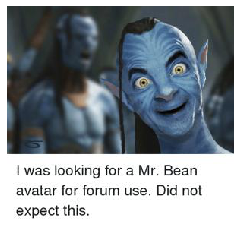

In [316]:
my_dict={0:'General',1:'Sarcasm',2:'Not-Sarcasm'}
i=correct_preds[0]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)

Prediction: Sarcasm
Actual: Sarcasm


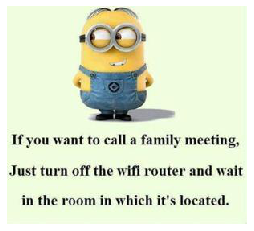

In [319]:
i=correct_preds[110]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)

#Incorrect Predictions

Prediction: Sarcasm
Actual: General


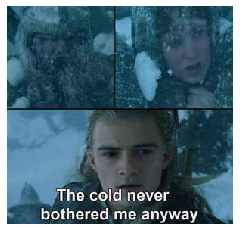

In [331]:
i=incorrect_preds[25]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)

Prediction: Sarcasm
Actual: General


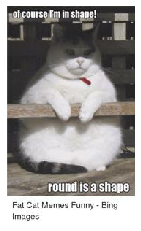

In [332]:
i=incorrect_preds[170]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)

#Using 300 dimensional pre-trained Glove Embeddings as weights for the Embedding layer

In [333]:
GLOVE_DIR='drive/My Drive/yelp_review_polarity_csv/'

import os
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [0]:
EMBEDDING_DIM = 300 # how big is each word vector

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LEN,
                            trainable=False)

#i) Dense BiLSTM model

In [0]:
inp = Input(shape=(MAX_SEQ_LEN,))
x = embedded_sequences = embedding_layer(inp)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(64)(x)
x = Dense(64)(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)

Train on 3000 samples, validate on 675 samples
Epoch 1/10
3000/3000 [==============================] - 3s 966us/sample - loss: 1.1240 - accuracy: 0.3420 - val_loss: 1.1073 - val_accuracy: 0.3274
Epoch 2/10
3000/3000 [==============================] - 1s 254us/sample - loss: 1.0687 - accuracy: 0.4283 - val_loss: 1.1252 - val_accuracy: 0.3319
Epoch 3/10
3000/3000 [==============================] - 1s 249us/sample - loss: 1.0009 - accuracy: 0.5023 - val_loss: 1.1824 - val_accuracy: 0.2904
Epoch 4/10
3000/3000 [==============================] - 1s 258us/sample - loss: 0.8140 - accuracy: 0.6450 - val_loss: 1.4278 - val_accuracy: 0.3022
Epoch 5/10
3000/3000 [==============================] - 1s 253us/sample - loss: 0.6089 - accuracy: 0.7467 - val_loss: 1.6941 - val_accuracy: 0.3289
Epoch 6/10
3000/3000 [==============================] - 1s 257us/sample - loss: 0.3746 - accuracy: 0.8570 - val_loss: 2.1944 - val_accuracy: 0.3319
Epoch 7/10
3000/3000 [==============================] - 1s 253us/

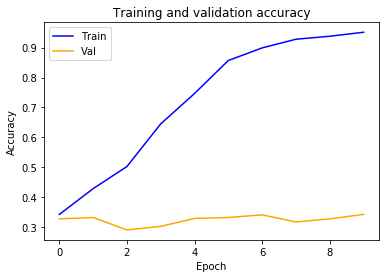

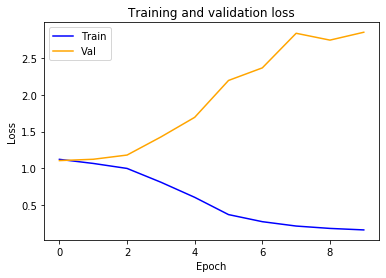

In [175]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)
plot(history)

In [0]:
y_pred = model.predict(padded_test)
y_pred=np.argmax(y_pred, axis=1)

In [180]:
from sklearn.metrics import classification_report
print(classification_report(x_test['sarcasm_tag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.35      0.24      0.29       224
         1.0       0.32      0.39      0.35       224
         2.0       0.30      0.32      0.31       224

    accuracy                           0.32       672
   macro avg       0.32      0.32      0.31       672
weighted avg       0.32      0.32      0.31       672



This model has an accuracy 32%

#Correct Predictions

In [0]:
correct_preds=[]
incorrect_preds=[]
for i in range(len(labels_test)):
  if labels_test[i]==y_pred[i]:
    correct_preds.append(i)
  else:
    incorrect_preds.append(i)


Prediction: Not-Sarcasm
Actual: Not-Sarcasm


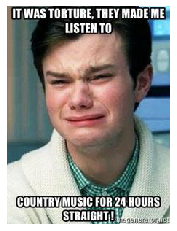

In [184]:
my_dict={0:'General',1:'Sarcasm',2:'Not-Sarcasm'}
i=correct_preds[100]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


Prediction: Sarcasm
Actual: Sarcasm


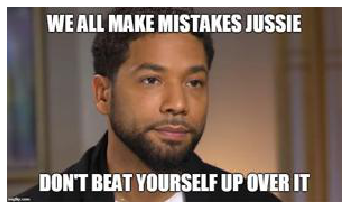

In [192]:
i=correct_preds[56]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


ii) Dense BiLSTM model with Dropout

In [0]:
inp = Input(shape=(MAX_SEQ_LEN,))
x = embedded_sequences = embedding_layer(inp)

x = LSTM(128)(x)
x = Dense(64)(x)
x = Dropout(0.5)(x)
x = Dense(64)(x)
x = Dropout(0.4)(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)

Train on 3000 samples, validate on 675 samples
Epoch 1/10
3000/3000 [==============================] - 2s 610us/sample - loss: 1.1477 - accuracy: 0.3263 - val_loss: 1.1006 - val_accuracy: 0.3437
Epoch 2/10
3000/3000 [==============================] - 1s 178us/sample - loss: 1.1009 - accuracy: 0.3723 - val_loss: 1.1061 - val_accuracy: 0.3363
Epoch 3/10
3000/3000 [==============================] - 1s 180us/sample - loss: 1.0836 - accuracy: 0.3997 - val_loss: 1.1152 - val_accuracy: 0.3496
Epoch 4/10
3000/3000 [==============================] - 1s 172us/sample - loss: 1.0643 - accuracy: 0.4193 - val_loss: 1.1258 - val_accuracy: 0.3496
Epoch 5/10
3000/3000 [==============================] - 1s 181us/sample - loss: 1.0374 - accuracy: 0.4583 - val_loss: 1.1495 - val_accuracy: 0.3422
Epoch 6/10
3000/3000 [==============================] - 1s 168us/sample - loss: 0.9988 - accuracy: 0.4860 - val_loss: 1.1840 - val_accuracy: 0.3422
Epoch 7/10
3000/3000 [==============================] - 1s 181us/

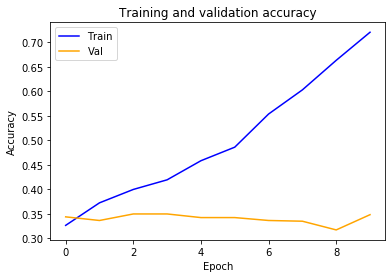

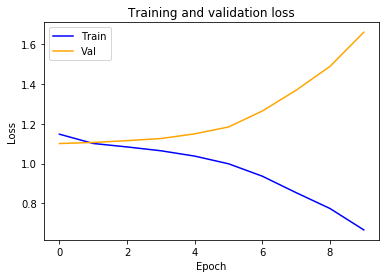

In [202]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)
plot(history)

In [0]:
y_pred = model.predict(padded_test)
y_pred=np.argmax(y_pred, axis=1)


In [205]:
print(classification_report(x_test['sarcasm_tag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.32      0.44      0.37       224
         1.0       0.32      0.25      0.28       224
         2.0       0.33      0.26      0.29       224

    accuracy                           0.32       672
   macro avg       0.32      0.32      0.31       672
weighted avg       0.32      0.32      0.31       672



This model has an accuracy 32%

In [0]:
correct_preds=[]
incorrect_preds=[]
for i in range(len(labels_test)):
  if labels_test[i]==y_pred[i]:
    correct_preds.append(i)
  else:
    incorrect_preds.append(i)

#Correct Predictions

Prediction: Not-Sarcasm
Actual: Not-Sarcasm


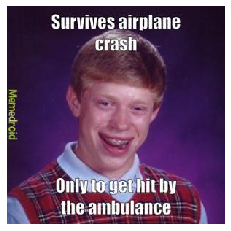

In [220]:
# Correct Predictions
i=correct_preds[67]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


Prediction: General
Actual: General


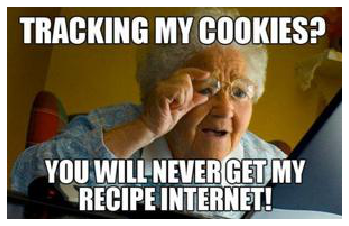

In [212]:
# Correct Predictions
i=correct_preds[175]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


# Incorrect Predictions

Prediction: General
Actual: Sarcasm


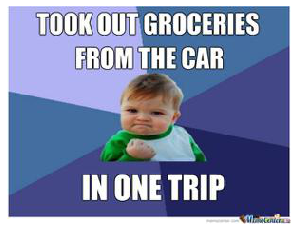

In [222]:
# Incorrect Predictions

i=incorrect_preds[55]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


Prediction: Not-Sarcasm
Actual: Sarcasm


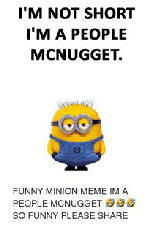

In [227]:
# Incorrect Predictions

i=incorrect_preds[87]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


#Results

We have used simple and deep LSTM and Bidirectional LSTM to fit models on our meme text data. We have also tried to use 300 dimensional pre-trained Glove embeddings for initialising the weights.
Dropout regularisation was used to prevent overfitting and improve validation accuracy.

The best models are baseline LSTM and Bidirectional LSTM with Dropout both had an accuracy of 33% for test data. However model baseline LSTM has an F1 score below 0.33 for 2 out of 3 classes. Whereas model Bidirectional LSTM with Dropout has F1 score below 0.33 for only 1 of its classes. 
We therefore conclude that model Bidirectional LSTM with Dropout performs the best on text only data from memes.  
